## DML-Project
Object detection and classification of strawberry ripeness

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchvision.io import read_image 
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import draw_bounding_boxes 
from itertools import chain
from PIL import Image
from pathlib import Path
import os
import matplotlib.patches as patches
import cv2
import IPython

### Image folders

In [2]:
train_data = "./images/train"
val_data   = "./images/valid"
test_data  = "./images/test"

### Load datasets and apply transformations

Mosaic augmentation,
flips and rotations,
resize,
zoom in,
crop

In [3]:
class StrawberryData(Dataset):
    
    def __init__(self, root, transform, ripe_label=0, unripe_label=1):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
            
        self.root = Path(root)
        self.transform = transform
        self._ripe_label = ripe_label
        self._unripe_label = unripe_label
        
        self.image_paths = [os.path.join(root, 'images', img_name) for img_name in os.listdir(os.path.join(root, 'images'))]
        self.label_paths = [os.path.join(root, 'labels', label_name) for label_name in os.listdir(os.path.join(root, 'labels'))]
        
        self.image_paths.sort()
        self.label_paths.sort()
        
        self._samples = self._collect_samples()
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """

        strawberry_paths_and_labels = map(lambda path: (self.__getitem__(path)), self.image_paths)
        return strawberry_paths_and_labels
        
        #strawberry_paths_and_labels = map(lambda path: (path, self._dog_label), strawberry_paths)
        #return sorted(list(strawberry_paths_and_labels), key=lambda x: x[0].stem)
     
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")

    @staticmethod
    def _collect_labels_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.txt")
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(image_path)

        with open(label_path, 'r') as f:
            annotations = f.readlines()
            annotations = list(map(lambda x: x.replace("\n", "").split(" "), annotations))

        if self.transform:
            image = self.transform(image)

        return image, annotations

    def __len__(self):
        return len(self.image_paths)

In [4]:
transform = Compose([ToTensor()])

train_dataset = StrawberryData(train_data, transform)
val_dataset   = StrawberryData(val_data, transform)
test_dataset  = StrawberryData(test_data, transform)

### Example image from the dataset

['1', '0.09375', '0.34765625', '0.134765625', '0.169921875']


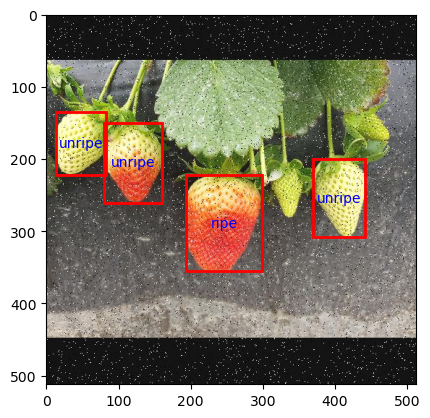

In [5]:
def display_image(axis, image_tensor, label):
    print(label[0])
    
    classification = {
        '0': 'ripe',
        '1': 'unripe'
    }

    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    axis.set_ylim(height, 0)
    for l in label:
            [lab, x1, y1, x2, y2] = l
            x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
            rect = patches.Rectangle(((x1-(x2/2))*width, (y1-(y2/2))*height), x2*width, y2*height, linewidth=2, edgecolor='r', facecolor='none', label="asd")
            axis.add_patch(rect)
            text = axis.text(x1*width, y1*height, classification[lab], color="blue", ha="center", va="center")
    plt.show()

_, axis = plt.subplots()
image_tensor, label = train_dataset[35]
display_image(axis, image_tensor, label)



### Dataloaders

In [6]:
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader   = DataLoader(val_dataset, batch_size=val_dataset.__len__())
test_data_loader  = DataLoader(test_dataset, batch_size=test_dataset.__len__())

### Calculate redness percentage

In [7]:
def calculate_redness_percentage(image, bbox):
    # Crop the bounding box region
    
    image_tensor, labels_and_bboxes = image
    labels = [sublist[0] for sublist in labels_and_bboxes]
    redness_percentages = []
    upper_crop_ratio = 0.9 #smaller value more crop
    for box in bbox:
        x, y, w, h = box
        
        #crop each strawberry from the image
        cropped_image = image_tensor[:,int(y - h / 2):int(y + h / 2), int(x - w / 2):int(x + w / 2)]
        
        transform = torchvision.transforms.ToPILImage()
        img = transform(cropped_image)
        
        cropped_im_w, cropped_im_h = img.size
        cropped_im_x = cropped_im_w // 2
        cropped_im_y = cropped_im_h // 2
        
        #cropping out upper part (hull) of the image (The hull or calyx is the green leafy top of the strawberry)
        crop_height = int(cropped_im_h * upper_crop_ratio)
        
        #new bbox coordinates
        x_new = cropped_im_x
        y_new = cropped_im_h - int(crop_height // 2)
        w_new = cropped_im_w
        h_new = crop_height
        
        #crop out the hull of the strawberry
        final_cropped_image = cropped_image[:, int(y_new - h_new / 2):int(y_new + h_new / 2), int(x_new - w_new / 2):int(x_new + w_new / 2)]
        np_cropped_image = final_cropped_image.numpy()
        
        transposed_cropped_image = np.transpose(final_cropped_image, (1, 2, 0))
        np_transposed_cropped_image = transposed_cropped_image.numpy()
        
        transform = torchvision.transforms.ToPILImage()
        img = transform(final_cropped_image)
        plt.imshow(img)
        plt.show()

        hsv = cv2.cvtColor(np_transposed_cropped_image, cv2.COLOR_RGB2HSV)

        lower1 = np.array([0,0,0])
        upper1 = np.array([10,255,255])

        lower2 = np.array([160, 0, 0])
        upper2 = np.array([179, 255, 255])

        lower_mask = cv2.inRange(hsv, lower1, upper1)
        upper_mask = cv2.inRange(hsv, lower2, upper2)
        
        full_mask = cv2.bitwise_or(lower_mask, upper_mask)
        
        plt.imshow(full_mask)
        plt.show()
        # Display the mask

        red_pixel_count = np.count_nonzero(full_mask)
        total_pixel_count = w * h

        redness_percentage = (red_pixel_count / total_pixel_count)
        formatted_redness_percentage = "{:.4f}".format(redness_percentage)
        print("redness percentage for this specific strawberry: ", formatted_redness_percentage)
        redness_percentages.append(formatted_redness_percentage)

    return redness_percentages, labels

[[48, 178, 55, 69], [120, 205, 64, 88], [406, 254, 57, 87], [246, 289, 84, 106]]


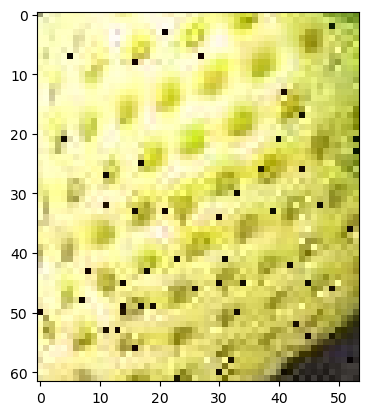

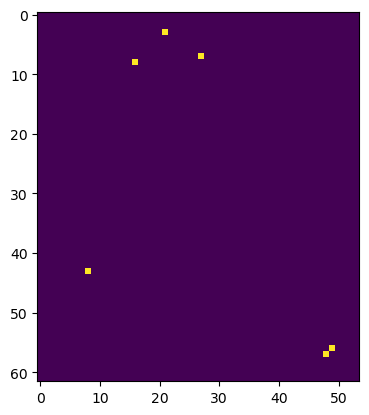

redness percentage for this specific strawberry:  0.0016


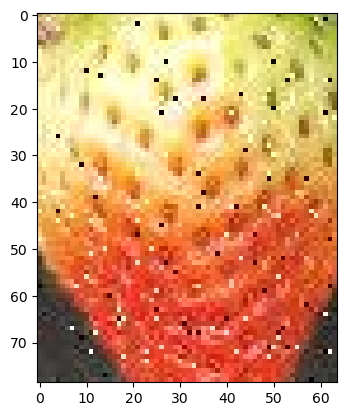

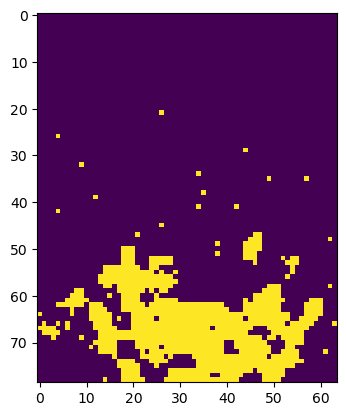

redness percentage for this specific strawberry:  0.1435


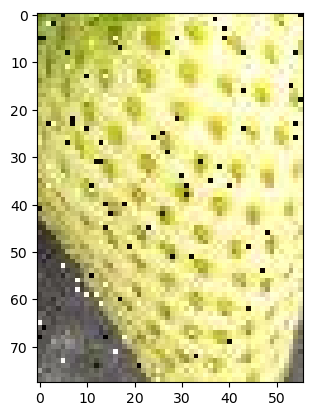

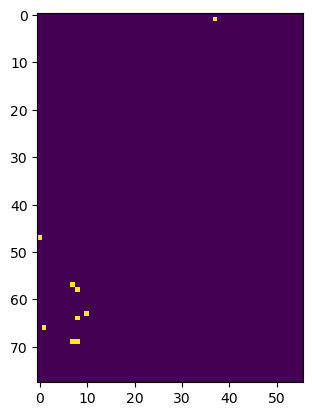

redness percentage for this specific strawberry:  0.0018


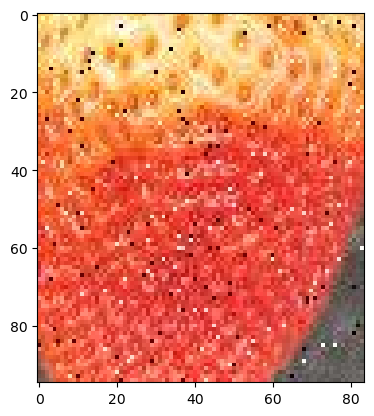

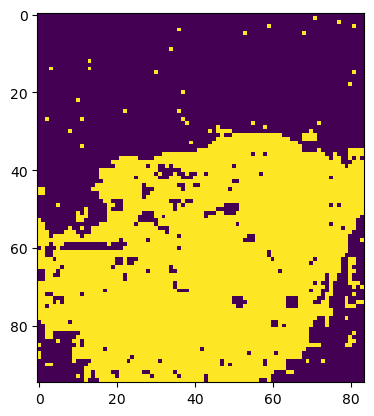

redness percentage for this specific strawberry:  0.4435
Redness Percentage:  ['0.0016', '0.1435', '0.0018', '0.4435']
Labels:  ['1', '1', '1', '0']


In [8]:
def get_bbox(label): #label is an array of labels for each image
    height = 512
    width = 512
    ratio = 0.8 #smaller value more zoom
    bbox = [] # bbox is an array of bounding boxes for each image with ratio applied
    for l in label:
            [lab, x1, y1, x2, y2] = l
            x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
            rect = patches.Rectangle(((x1-(x2/2))*width, (y1-(y2/2))*height), x2*width, y2*height, linewidth=2, edgecolor='r', facecolor='none', label="asd")
            x_center, y_center = rect.get_center()
            #get original bbox dimensions
            w = rect.get_width()
            h = rect.get_height()
            #zooming in the bounding box by reducing width and height
            new_w = w*ratio
            new_h = h*ratio
            bb = [int(x_center), int(y_center), int(new_w), int(new_h)]
            bbox = bbox + [bb]
    return bbox

#def reduce_bbox(bbox):
#    ratio = 0.75
#    new_bboxes = []
#    for box in bbox:
#        x, y, w, h = box
#        new_width = w*ratio
#        new_height = h*height
#        new_bbox = [x, y, new_width, new_height]
#        new_bboxes = new_bboxes + [new_bbox]
#    return new_bboxes
        

# Define bounding box coordinates (x, y, width, height)
bbox = get_bbox(label) # array of bounding boxes

image_width = 512
image_height = 512

def unnormalize_bbox(normalized_bbox, image_width, image_height):
    unnormalized_bbox = []
    for bbox in normalized_bbox:
        x, y, w, h = bbox
        x_pixel = int(x * image_width)
        y_pixel = int(y * image_height)
        width_pixel = int(w * image_width)
        height_pixel = int(h * image_height)
        unnormalized_bbox = unnormalized_bbox + [[x_pixel, y_pixel, width_pixel, height_pixel]]
    return unnormalized_bbox #array of unnormalized bboxes

print(bbox)


# Calculate the redness percentage
redness_percentage, labels = calculate_redness_percentage(train_dataset[35], bbox) #image tensor and array of unnormalized_bboxes
print("Redness Percentage: ", redness_percentage)
print("Labels: ", labels)

### YOLOv5
#### Install

In [9]:
#!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

#### Run the training script

To train the YOLOv5 with our own images we need can create our own data config file that specifies the location where our images and labels are. And what classes we want it to find. This can be done by simply creating a yaml file that specifies all the locations and labels.

Firstly, we download the yolov5 repo and install the dependencies, this should be done in the same folder as `dml-project`.

Run the following from the terminal:
```
git clone https://github.com/ultralytics/yolov5  # clone
cd yolov5
pip install -r requirements.txt  # install
```
We can then use our `strawberryripness.yaml` that looks like:

```
path: ../dml-project # dataset root dir
train: images/train # train images (relative to 'path')
val: images/valid # val images (relative to 'path')
test: images/test # test images

names:
    0: ripe
    1: unripe
```


Then we can perform training by running:

In [10]:
#!python ../yolov5/train.py --img 512 --batch-size 32 --epochs 150 --data strawberryripeness.yaml --weights yolov5s.pt

What this does is basically running the yolov5 training script for 150 epochs with the pretrained weights and our defined classes and labels. From this we get new weights that are saved in the `strawberries.pt` file. 

Here is how the result came back after training with the strawberries!

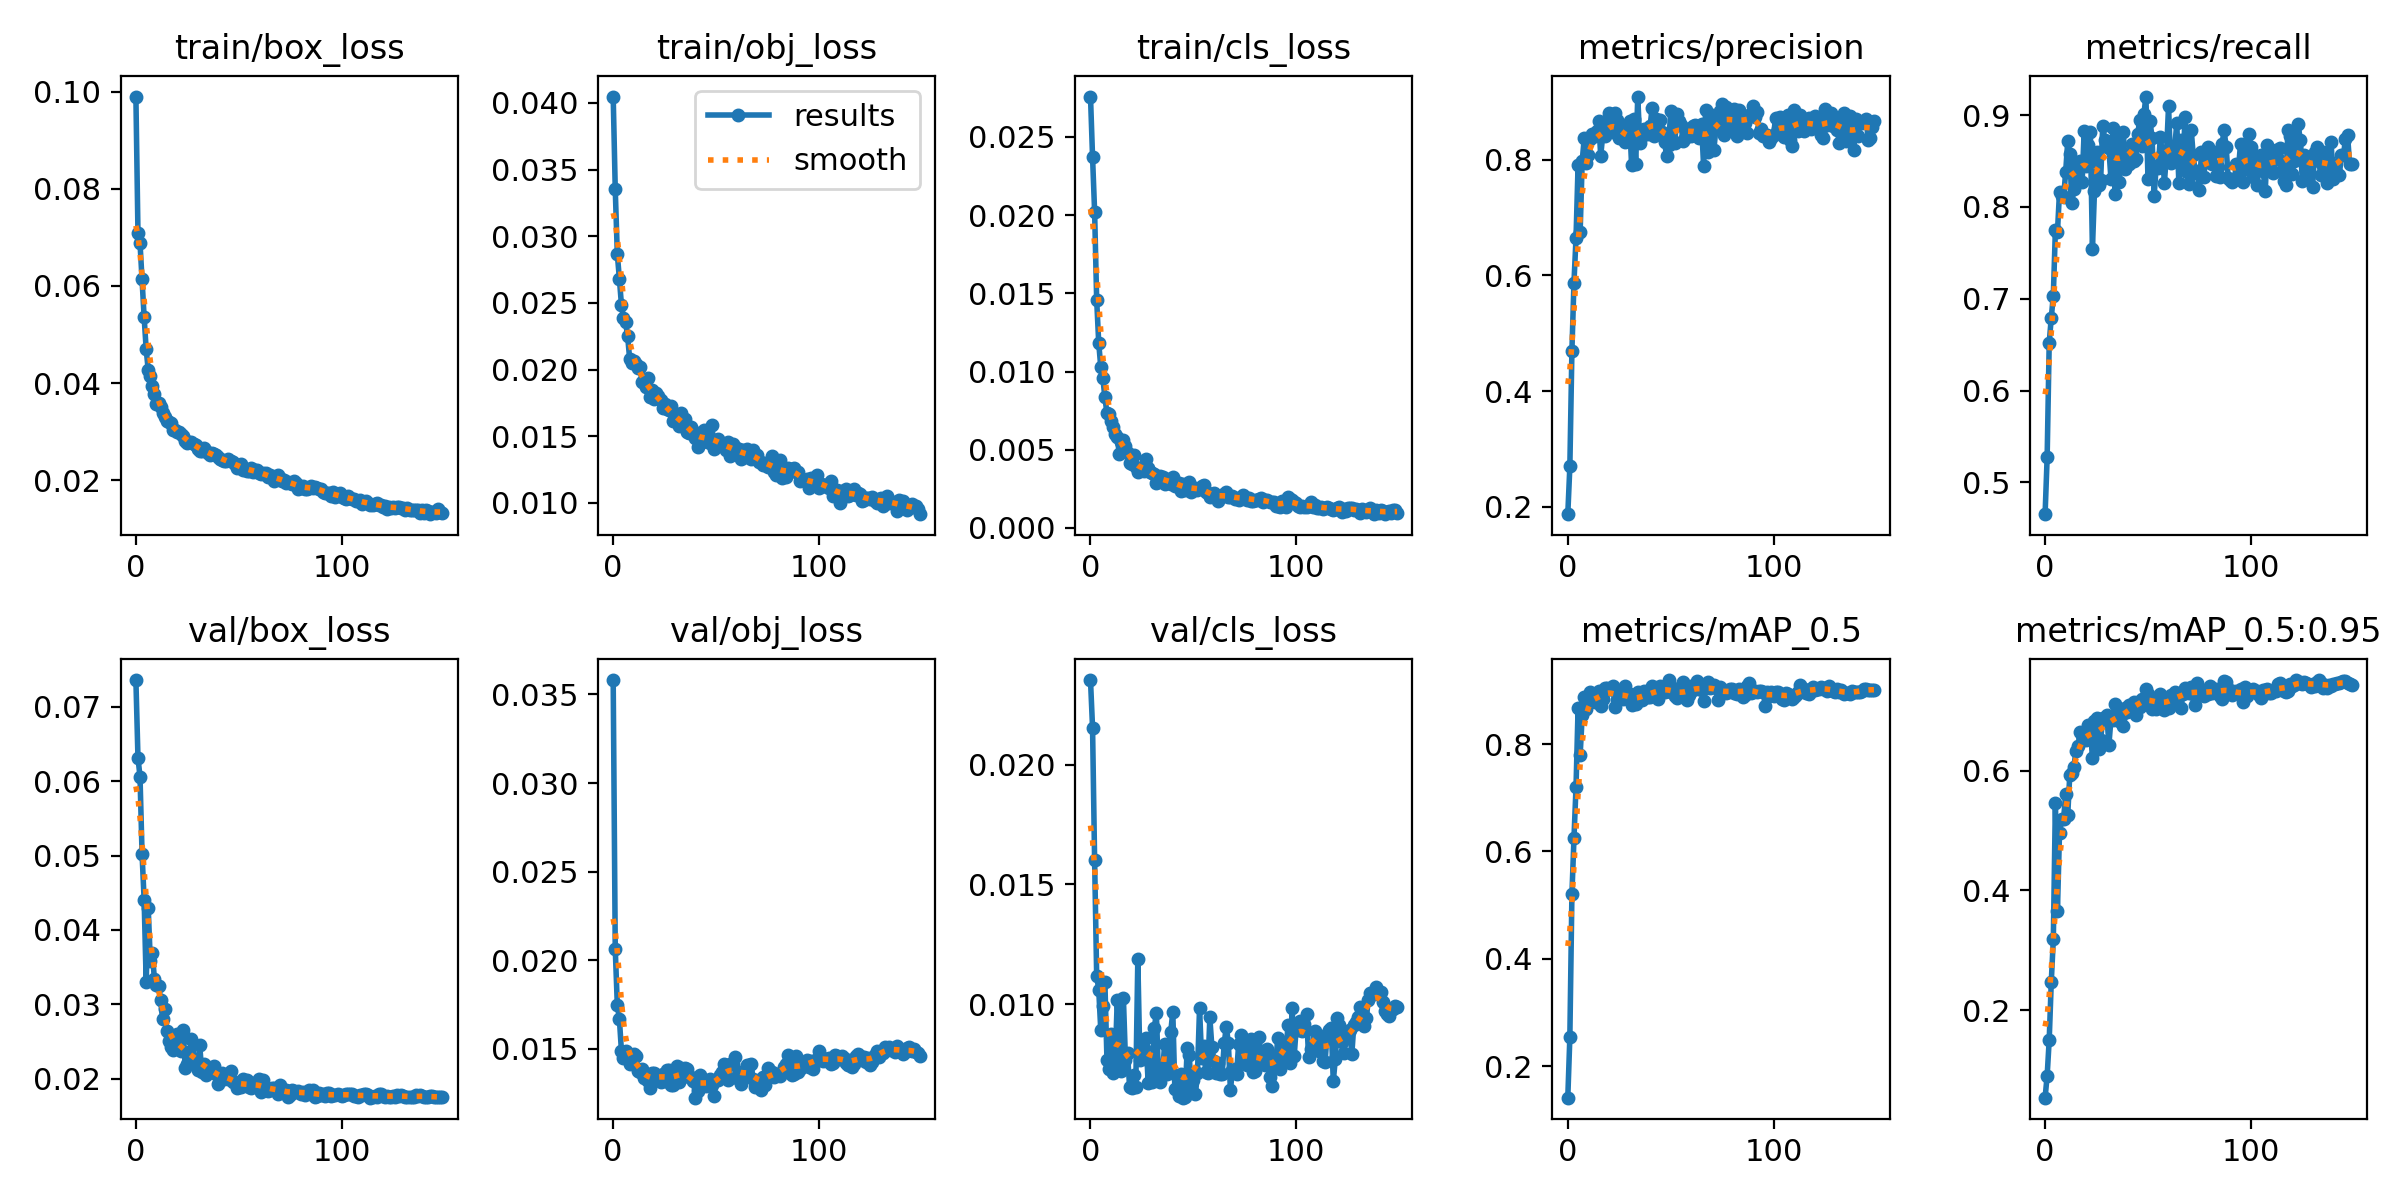

In [11]:
IPython.display.Image('./results.png')

#### Now we can validate the model

This is done in a similar fashion to the training, we run:

In [12]:
#!python ../yolov5/val.py --weights strawberries.pt --data strawberryripeness.yaml --img 512

And this is how some of the predictions done by the validation looked

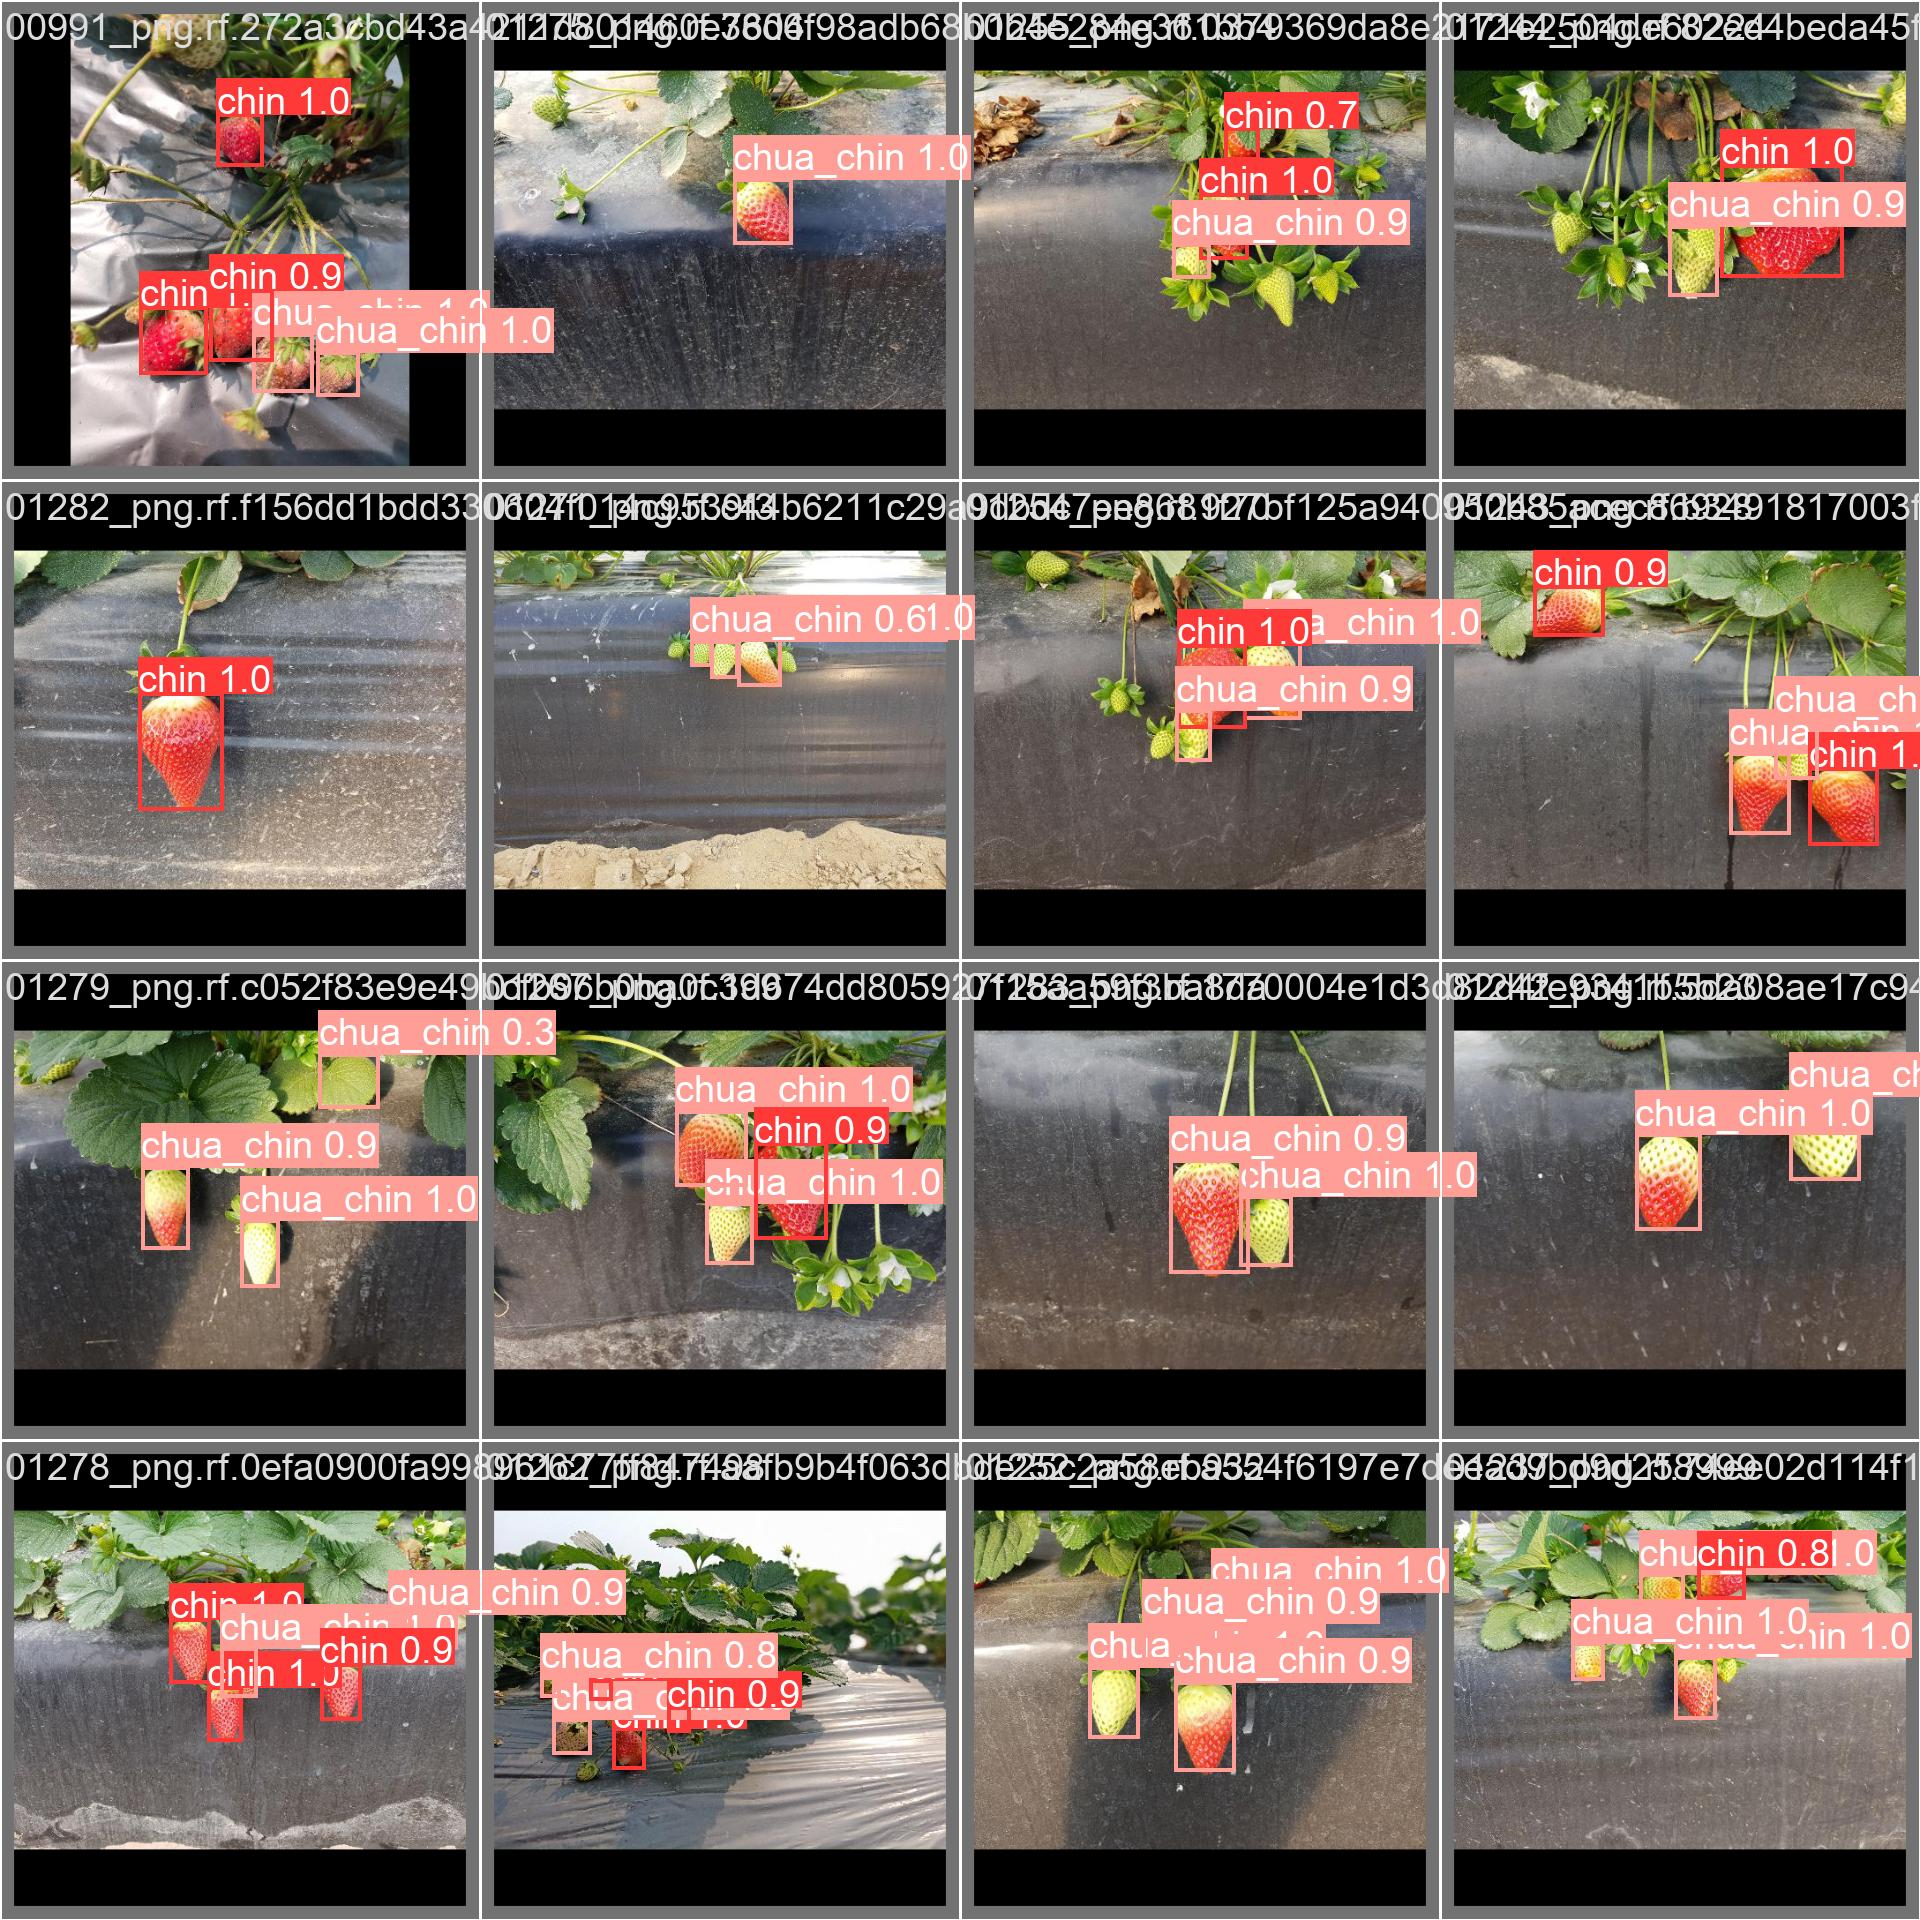

In [13]:
IPython.display.Image('val_batch0_pred.jpg')


#### Import the model

Now we can import the model using pytorch and the trained weights

We can then look at specific examples of it detecting strawberries

In [14]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='strawberries.pt')

Using cache found in C:\Users\curbanos/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-10-8 Python-3.9.17 torch-1.11.0 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


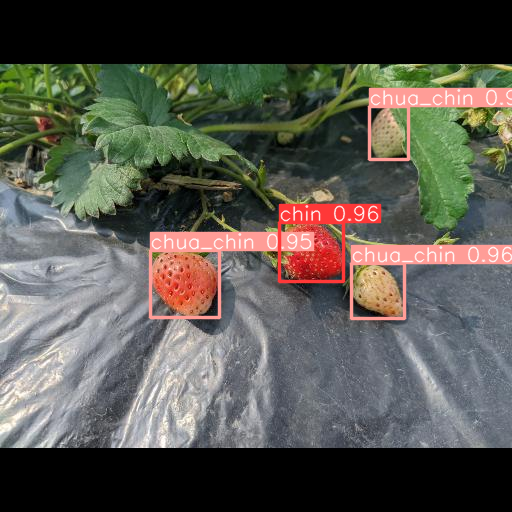

In [15]:
im = './images/test/images/00481_png.rf.147a45e27afacce08a40b158204a3231.jpg'
results = model(im)
results.show()

Todo
- Function for itterating over the yolov5 result
- function for parsing the yolo boundingboxes and cropping out the color
- model for regressing on color of the previous mentioned cropped boxes
- evaluation and so forth